# Ajuste de Oultiers
El presente notebook presenta un algoritmo para suavizar outliers en series temporales de variables atmósfericas. Se trabaja con los valores obtenidos por una red inalámbrica de sensores desplegada en un cultivo de cacao en una vereda del municipio de San Cayetano, Norte de Santander. Las mediciones analizadas corresponden a las variables atmósfericas Temperatura, Humedad Relativa, Humedad de la Tierra e Intensidad Lumínica.

In [1]:
# Se importan los módulos necesarios
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import cm
import seaborn as sns
import funs
from scipy.stats.stats import pearsonr

# Se define un límite para las filas de los dataframes que se presenten en el notebook
pd.options.display.max_rows = 10

In [2]:
# Importa los datos correspondientes al nodo 2
nodo = 2
mediciones_cacao = pd.read_csv('mediciones_cacao_n%s.csv' %nodo)
#mediciones_cacao.loc[:, 'TIME'] = [pd.Timestamp(x) for x in mediciones_cacao['TIME']]
mediciones_cacao.drop('NIVEL UV',axis=1,inplace=True)

# Crea dos copias de los datos, filtrado para realzar un filtro de valores atípicos
# según el rango de medición y ajustado para suavizar la curva 
filtrado = mediciones_cacao.copy()
ajustado = mediciones_cacao.copy()

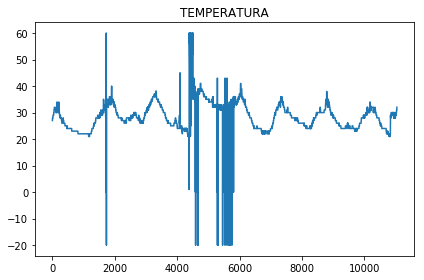

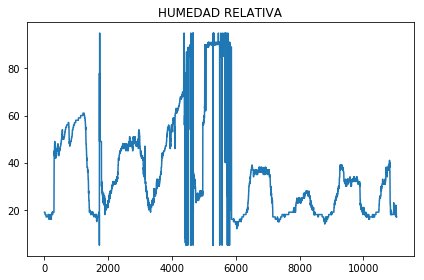

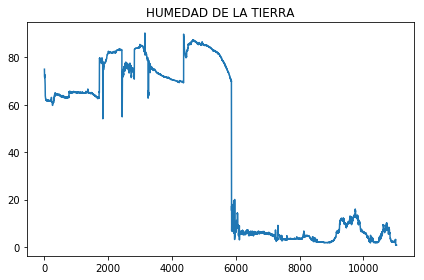

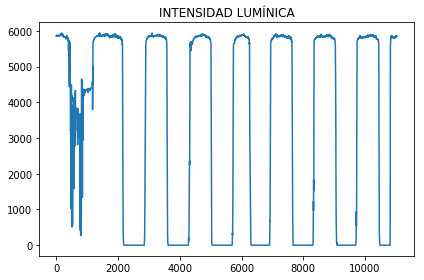

In [3]:
# Grafica las variables  de interes
a=510
for i in range(0,4):
    a+=1
    #plt.subplot(a)
    plt.figure()
    plt.plot(mediciones_cacao.iloc[:,i])
    plt.title(mediciones_cacao.columns[i])
    plt.tight_layout()


A partir de los gráficos de los valores medidos es posible deducir relaciones existentes entre las variables:
- Relación de proporcionaliad inversa entre la temperatura y la humedad relativa.
- Correlación positiva entre la humedad relativa y la humedad del suelo.
- Correspodencia de los valores máximos de intensidad lumínica con los ciclos positivos de temperatura.

Correlaciones positivas
- Temperatura - Intensidad Lumínica.
- Humedad Relativa - Humedad de la Tierra.

Correlaciones negativas
- Temperatura - Humedad Relativa
- Temperatura - Humedad de la Tierra.
- Humedad Relativa - Intensidad Lumínica.

A continuación se realiza un grafico de matriz de correlación para visualizar mejor la relación entre las varibles.

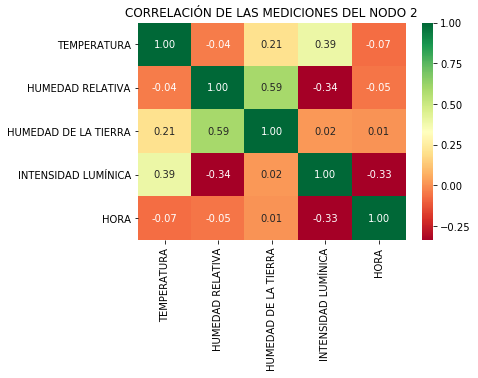

In [4]:
sns.heatmap(mediciones_cacao.corr(), annot=True, cmap='RdYlGn',fmt=".2f")
plt.title('CORRELACIÓN DE LAS MEDICIONES DEL NODO %s' %nodo)
plt.show()

Se aplica un filtro para ajustar el rango de valores medidos de las variables, variando el mismo desde un límite máximo basado en el rango de medida del sensor, hasta el rango definido por el criterio de Tukey para los valores de la variable. Finalmente se selecciona el rango que garantice la mejor correlación entre las variables.

In [5]:
print(mediciones_cacao.corr())

                      TEMPERATURA  HUMEDAD RELATIVA  HUMEDAD DE LA TIERRA  \
TEMPERATURA              1.000000         -0.035090              0.210159   
HUMEDAD RELATIVA        -0.035090          1.000000              0.594785   
HUMEDAD DE LA TIERRA     0.210159          0.594785              1.000000   
INTENSIDAD LUMÍNICA      0.394743         -0.336219              0.023028   
HORA                    -0.066693         -0.051088              0.009354   

                      INTENSIDAD LUMÍNICA      HORA  
TEMPERATURA                      0.394743 -0.066693  
HUMEDAD RELATIVA                -0.336219 -0.051088  
HUMEDAD DE LA TIERRA             0.023028  0.009354  
INTENSIDAD LUMÍNICA              1.000000 -0.331241  
HORA                            -0.331241  1.000000  


El sensor DHT11 tiene rangos de medición de:  
- Temperatura de $(20°C - 50°C)\pm5°C$  
- Humedad Ralativa de $(20\% - 90\%)\pm2\%$

L arelación entre la temperatura y la humedad relativa es de una correlación negativa


In [6]:
def info_var(v):
    'Grafica todos los valores medidos para la variable v'
    variable = mediciones_cacao.columns[v]
    
    plt.plot(mediciones_cacao[variable],'orange',label='datos')
    plt.title(variable)
    plt.legend()
    
def tukey(variable):
    'Obtiene los límites superiores e inferiores para v'
    
    RIQ = variable.quantile(q=.75) - variable.quantile(q=.25)
    Li = variable.quantile(q=.25) - RIQ * 1.5
    Ls = variable.quantile(q=.75) + RIQ * 1.5
    return Li, Ls
def filtro(variable,i,q):
    'Iguala el valor de una medición a un determinado valor límite'
    global filtrado
    
    try:
        filtrado[variable][i] = filtrado[variable][i-120:i].median()   
        
    except KeyError:
        filtrado[variable][i]= q
    return
    filtrado[variable].plot(label='filtrado')

def filtro_var(v,lim_i,lim_s):
    'Ajusta los valores atípicos en las mediciones de la variable v'
    
    global filtrado
    variable=filtrado.columns[v]
    Li, Ls = tukey(filtrado[variable])

    for i in range(len(filtrado[variable])):
              
        if filtrado[variable][i] >= lim_s:
            filtro(variable,i,filtrado[variable].quantile(.75))
        
        elif filtrado[variable][i] <= lim_i:
            filtro(variable,i,filtrado[variable].quantile(.25))
            
        elif filtrado[variable][i] >= Ls and Ls > lim_s:
            filtro(variable,i,filtrado[variable].quantile(.75))
            
        elif filtrado[variable][i] <= Li and Li < lim_i:
            filtro(variable,i,filtrado[variable].quantile(.25))
    return filtrado.corr()

def up_ajuste(filtrado,v):
    global ajustado
    variable=ajustado.columns[v]
    ajustado[variable]=filtrado[variable].copy()
    return

def ajuste_variacion(v):
    'Ajusta los valores que presentan una variación superior a la std'
    global ajustado
    up_ajuste(filtrado,v)
    variable=ajustado.columns[v]
    ventana=60
    rolling_std = ajustado[variable].rolling(ventana).std()
    rolling_std_inv=ajustado[variable].iloc[::-1].rolling(ventana).std().iloc[::-1]
    indice=rolling_std[rolling_std.isnull().values].index
    rolling_std[indice[0]]=rolling_std_inv[indice[0]]

    nvalores=ajustado[variable][rolling_std>(rolling_std.mean())].index.values
    rolling_median=ajustado[variable].rolling(ventana).median()
    rolling_median_inv=ajustado[variable].iloc[::-1].rolling(ventana).median().iloc[::-1]
    indice=rolling_median[rolling_median.isnull().values].index
    rolling_median[indice[0]]=rolling_median_inv[indice[0]]
    suave=ajustado[variable].copy()
    suave[nvalores]=rolling_median[nvalores+ventana]
    plt.figure()
    plt.plot(filtrado[variable],label='filtrado')
    plt.plot(suave,label='suavizado')
    plt.legend()
    ajustado[variable]=suave
    return


C:\Users\Jergb\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,TEMPERATURA
TEMPERATURA,1.000000
HUMEDAD RELATIVA,-0.313705
HUMEDAD DE LA TIERRA,0.210159
INTENSIDAD LUMÍNICA,0.394743
HORA,-0.066693


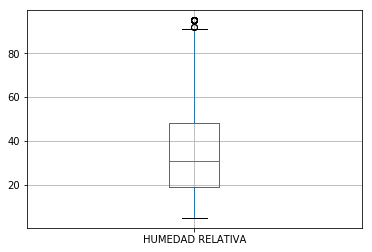

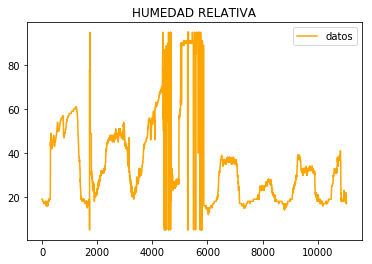

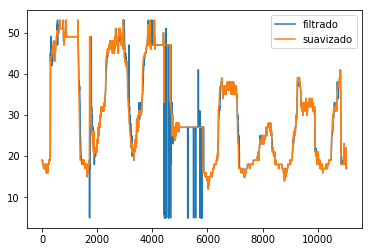

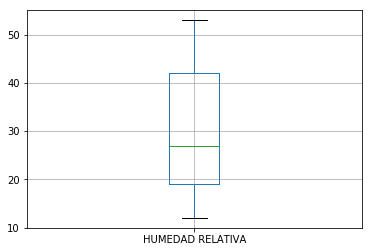

In [7]:
(mediciones_cacao.iloc[:,1:2]).boxplot()
plt.figure()

info_var(1)
filtro_var(1,0,54)
ajuste_variacion(1)

plt.figure()

(ajustado.iloc[:,1:2]).boxplot()
filtrado.corr().iloc[:,0:1]

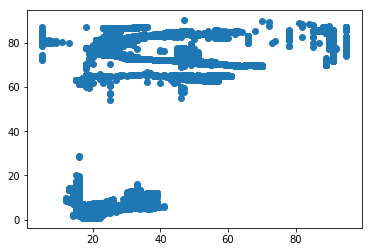

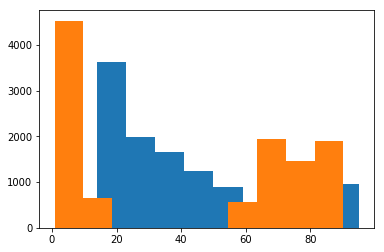

In [8]:
plt.scatter(mediciones_cacao.iloc[:,1],mediciones_cacao.iloc[:,2])
plt.figure()
plt.hist(mediciones_cacao.iloc[:,1])
plt.hist(mediciones_cacao.iloc[:,2])
plt.show()

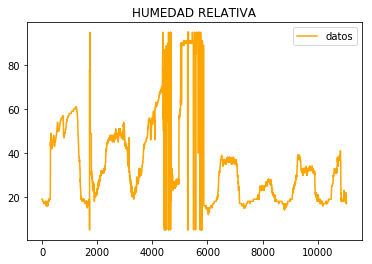

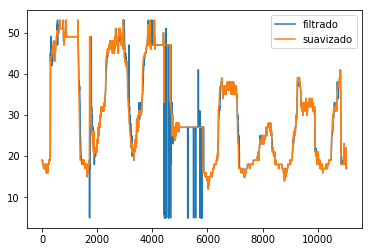

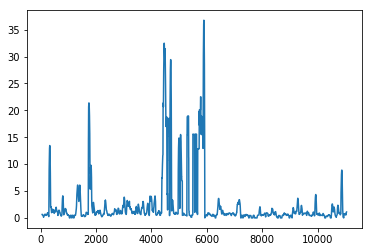

In [9]:
info_var(1)
filtro_var(1,0,54)
ajuste_variacion(1)
plt.figure()
plt.plot(mediciones_cacao.iloc[:,1].rolling(60).std())

C:\Users\Jergb\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


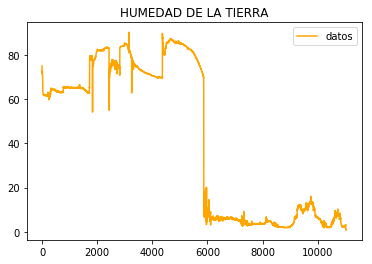

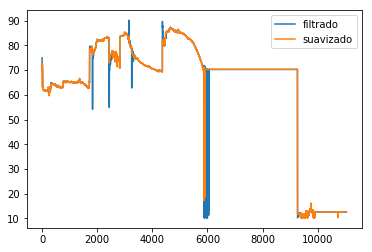

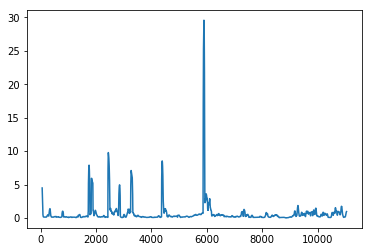

In [10]:
info_var(2)
filtro_var(2,10,100)
ajuste_variacion(2)
plt.figure()
plt.plot(mediciones_cacao.iloc[:,2].rolling(60).std())

In [11]:
-1<3


True

C:\Users\Jergb\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jergb\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


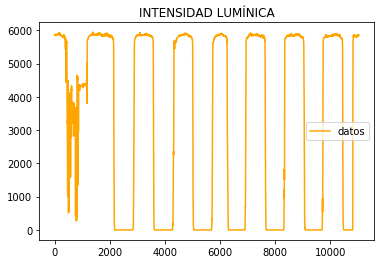

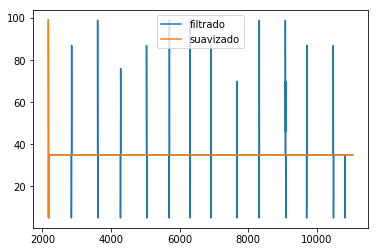

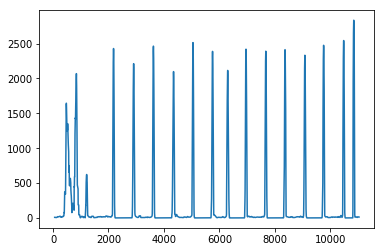

In [12]:
info_var(3)
filtro_var(3,0,100)
ajuste_variacion(3)
plt.figure()
plt.plot(mediciones_cacao.iloc[:,3].rolling(60).std())

C:\Users\Jergb\Anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


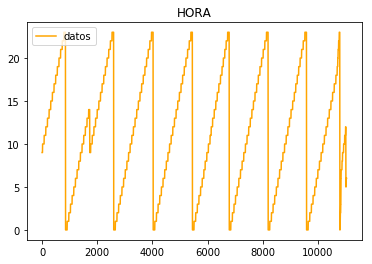

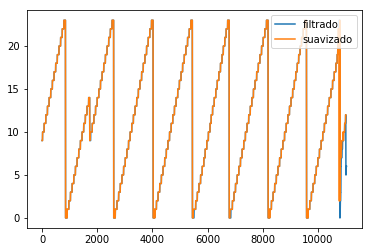

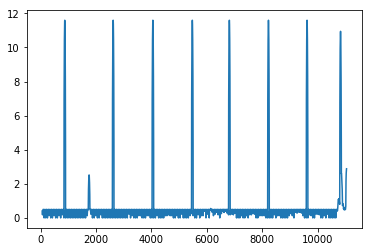

In [13]:
info_var(4)
filtro_var(4,-10,6000)
ajuste_variacion(4)
plt.figure()
plt.plot(mediciones_cacao.iloc[:,4].rolling(60).std())

In [14]:
mediciones_cacao['NODO'].replace(to_replace=[nodo], value='Nodo%s'%nodo, inplace=True) 
sns.pairplot(mediciones_cacao,hue='NODO',plot_kws=dict(s=10),diag_kind='kde')
plt.show()

KeyError: 'NODO'

In [ ]:
ajustado['NODO'].replace(to_replace=[nodo], value='Nodo%s' %nodo, inplace=True) 
sns.pairplot(ajustado,hue='NODO',plot_kws=dict(s=10),diag_kind=('kde'))
plt.show()

In [ ]:
filtrado['NODO'].replace(to_replace=[nodo], value='Nodo%s' %nodo, inplace=True) 

sns.heatmap(mediciones_cacao.corr(), annot=True, cmap='RdYlGn',fmt=".2f")
plt.title('CORRELACIÓN DE LAS MEDICIONES DEL NODO %s' %nodo)
plt.figure()
sns.heatmap(filtrado.corr(), annot=True, cmap='RdYlGn',fmt=".2f")
plt.title('MEDICIONES FILTRADAS DEL NODO %s' %nodo)
plt.figure()
sns.heatmap(ajustado.corr(), annot=True, cmap='RdYlGn',fmt=".2f")
plt.title('MEDICIONES AJUSTADAS DEL NODO %s' %nodo)
plt.show()